# Capstone 2 Proposal

## <span style="color:blue"> Mandar Kulkarni, Ph.D.</span>

### Question2. Python Task: Timeseries Forecast

You are given a dataset consisting of energy consumption (see usage.csv) for two types - Residential (RESI) and Commercial (COMM). The data provided is 4 years of data from 2017 through 2020 at the daily, hourly resolution. You are given weather data (weather.csv) for the years 2017-2021 at the daily, hourly resolution and a mapping file (attributes.csv), that maps the type of consumption to the weather station A. 

The columns to connect attributes and weather data is to join geoid column on the weather station with the attribute_type (weather_id) on the attributes file. The weather data for A provided is in the time zone mentioned in the usage.csv file. 

Given this:
    1. Convert the usage data to the following format based on the instructions below. Write the dataset out in the parquet format (needs to be sent across to us).  
        i. uid – as given
        ii. start_time - YYYY-MM-DDTHH:mm:ss in [UTC] (https://www.nhc.noaa.gov/aboututc.shtml) and inclusive, using the columns proxy_date and value_interval. The value_interval int1…int24 represents the hour. 
        iii. proxy_date – YYYY-MM-DD - Date of start_time in local time.
        iv. timezone – timezone column already mentioned
        v. value – value column already in the dataset
        
    2. Predict the consumption of usage for 4 months of 2021 from January to April end (out of sample) for the RESI and COMM types mentioned in the attributes.csv file. Predict them at the daily, hourly level which is the same resolution as the input consumption and the weather dataset. A sample output labelled sample_predict.csv is also provided. That should be the output format of the prediction expected. Please send your prediction output to us.  

Show work through appropriate cross validation techniques, models used, model statistics (e.g.: - R^2, feature importances etc.), and optionally, any supporting visualizations. Performance would be measured by using MAPE (Mean Absolute percentage error), the formula for which is given as-
    $MAPE = 100*\frac{\sum_{t=1}^{n}|A_t-F_t|}{\sum_{t=1}^{n}|A_t|}$ where $A_t$ is actual value & $F_t$ is forecast value. 
    Here, in the numerator, calculate the absolute error for each day and hour and sum it up for each month and in the denominator, sum the usage consumption for the month. Divide the two to get the metric for MAPE.


In [1]:
#Import relevant libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 50)

##### Let's read the <code>usage</code> & <code>weather</code> datasets.

In [2]:
# Reading the usage and weather datasets
df_use = pd.read_csv('usage.csv')
df_wea = pd.read_csv('weather.csv')

In [3]:
# List top 5 rows of the usage dataset
df_use.head()

,uid,proxy_date,timezone,value_interval,value_type,value
0,COMM,2017-01-01,America/Chicago,int1,Net,164.328000
1,COMM,2017-01-01,America/Chicago,int2,Net,169.769996
2,COMM,2017-01-01,America/Chicago,int3,Net,169.818004
3,COMM,2017-01-01,America/Chicago,int4,Net,171.738003
4,COMM,2017-01-01,America/Chicago,int5,Net,169.038003


In [4]:
# List bottom 5 rows of the usage dataset
df_use.tail()

,uid,proxy_date,timezone,value_interval,value_type,value
69803,RESI,2020-12-31,America/Chicago,int20,Net,1.756799
69804,RESI,2020-12-31,America/Chicago,int21,Net,1.654975
69805,RESI,2020-12-31,America/Chicago,int22,Net,1.577075
69806,RESI,2020-12-31,America/Chicago,int23,Net,1.496837
69807,RESI,2020-12-31,America/Chicago,int24,Net,1.401601


In [5]:
# Data consists of both Commercial and Residential Users. Lets list shapes of all, commercial only and residential only
print(df_use.shape)
print(df_use[df_use['uid']=='COMM'].shape)
print(df_use[df_use['uid']=='RESI'].shape)

(69808, 6)
(34748, 6)
(35060, 6)


###### There are 69808 entries in the usage dataframe of which 34748 entries are for commercial consumption and 35060 are for residential consumption.

In [6]:
# List various datatypes being used in df_use
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69808 entries, 0 to 69807
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   uid             69808 non-null  object 
 1   proxy_date      69808 non-null  object 
 2   timezone        69808 non-null  object 
 3   value_interval  69808 non-null  object 
 4   value_type      69808 non-null  object 
 5   value           62512 non-null  float64
dtypes: float64(1), object(5)
memory usage: 3.2+ MB


In [7]:
#Check for missing values
na_df_use=pd.DataFrame(df_use.isnull().sum().sort_values(ascending=False)).reset_index()
na_df_use.columns = ['VarName', 'NullCount']
na_df_use[(na_df_use['NullCount']>0)]

,VarName,NullCount
0,value,7296


In [8]:
#Lets separate the missing values by usage type (commercial vs residential)
#First lets look at commercial values
na_comm_df_use=pd.DataFrame(df_use[df_use['uid']=='COMM'].isnull().sum().sort_values(ascending=False)).reset_index()
na_comm_df_use.columns = ['VarName', 'NullCount']
na_comm_df_use[(na_comm_df_use['NullCount']>0)]

,VarName,NullCount
0,value,3624


In [9]:
#Next, lets look at residential values
na_comm_df_use=pd.DataFrame(df_use[df_use['uid']=='RESI'].isnull().sum().sort_values(ascending=False)).reset_index()
na_comm_df_use.columns = ['VarName', 'NullCount']
na_comm_df_use[(na_comm_df_use['NullCount']>0)]

,VarName,NullCount
0,value,3672


##### There are 7296 missing entries for the <code>values</code> (usage) column of which, 3624 are from commercial usage and 3672 from residential usage.

In [10]:
# List top 5 rows of the weather dataset
df_wea.head()

,weather_day,weather_hour,temperature,dew_point,humidity,heat_index,wind_chill,wind_direction,wind_speed,cloud_cover,wet_bulb_temp,solar_irradiance,precipitation,geoid,process_time
0,2017-01-01,1,48.0,36.0,63.0,48.0,45.5,330.0,5.8,50.0,42.3,0.0,0.0,A,2021-05-17T00:00:00
1,2017-01-01,2,46.9,37.9,71.0,46.9,43.0,320.0,8.1,50.0,42.6,0.0,0.0,A,2021-05-17T00:00:00
2,2017-01-01,3,46.0,37.0,71.0,46.0,43.0,330.0,5.8,50.0,41.7,0.0,0.0,A,2021-05-17T00:00:00
3,2017-01-01,4,45.0,37.0,74.0,45.0,41.7,330.0,5.8,50.0,41.2,0.0,0.0,A,2021-05-17T00:00:00
4,2017-01-01,5,43.0,37.0,79.0,43.0,38.1,295.0,8.1,75.0,40.1,0.0,0.0,A,2021-05-17T00:00:00


In [11]:
# List bottom 5 rows of the weather dataset
df_wea.tail()

,weather_day,weather_hour,temperature,dew_point,humidity,heat_index,wind_chill,wind_direction,wind_speed,cloud_cover,wet_bulb_temp,solar_irradiance,precipitation,geoid,process_time
43814,2021-12-31,20,48.592857,33.896429,60.135714,48.592857,45.577143,0.0,0.0,0.0,42.174286,0.0,0.0,A,2021-05-18T00:00:00
43815,2021-12-31,21,47.612143,33.847857,61.757143,47.612143,44.216429,0.0,0.0,0.0,41.635714,0.0,0.0,A,2021-05-18T00:00:00
43816,2021-12-31,22,46.502143,33.710714,63.735714,46.502143,42.782143,0.0,0.0,0.0,41.001429,0.0,0.0,A,2021-05-18T00:00:00
43817,2021-12-31,23,45.675000,33.520714,64.935714,45.675000,41.956429,0.0,0.0,0.0,40.504286,0.0,0.0,A,2021-05-18T00:00:00
43818,2021-12-31,24,44.774286,34.470000,69.350000,44.774286,41.148571,0.0,0.0,0.0,40.444286,0.0,0.0,A,2021-05-18T00:00:00


In [12]:
#List the shape of the weather dataset
df_wea.shape

(43819, 15)

In [13]:
wepd_df = df_wea['weather_day'].value_counts().reset_index()
wepd_df.columns = ['weather_day', 'num_entries']
wepd_df

,weather_day,num_entries
0,2017-01-01,24
1,2020-05-11,24
2,2020-05-09,24
3,2020-05-08,24
4,2020-05-07,24
...,...,...
1821,2017-03-12,23
1822,2020-03-08,23
1823,2018-03-11,23
1824,2021-03-14,23


In [14]:
wepd_df[wepd_df['num_entries']==23]

,weather_day,num_entries
1821,2017-03-12,23
1822,2020-03-08,23
1823,2018-03-11,23
1824,2021-03-14,23
1825,2019-03-10,23


##### The weather dataset is from Jan 01 2017 to Dec 31 2021. This 5 year span has 1826 days. For 5 out of 1826 days, we have 23 data points. These 5 days correspond to the ("spring forward") days when daylight saving started in those respective year causing "loss" of one hour. 

In [15]:
#Check weather entries on the 'fall-back' day in 2017
df_wea[df_wea['weather_day']=='2017-11-05']

,weather_day,weather_hour,temperature,dew_point,humidity,heat_index,wind_chill,wind_direction,wind_speed,cloud_cover,wet_bulb_temp,solar_irradiance,precipitation,geoid,process_time
7391,2017-11-05,1,75.9,69.1,79.0,75.9,75.9,190.0,15.55,87.5,70.9,0.0,0.0,A,2021-05-17T00:00:00
7392,2017-11-05,2,75.9,69.1,79.0,75.9,75.9,190.0,13.90,100.0,70.9,0.0,0.0,A,2021-05-17T00:00:00
7393,2017-11-05,3,75.0,69.1,82.0,75.0,75.0,190.0,12.80,100.0,70.7,0.0,0.0,A,2021-05-17T00:00:00
7394,2017-11-05,4,73.9,69.1,85.0,73.9,73.9,190.0,11.40,100.0,70.3,0.0,0.0,A,2021-05-17T00:00:00
7395,2017-11-05,5,73.0,69.1,87.0,73.0,73.0,190.0,17.20,75.0,70.2,0.0,0.0,A,2021-05-17T00:00:00
7396,2017-11-05,6,72.0,68.0,87.0,72.0,72.0,180.0,15.00,100.0,69.1,0.0,0.0,A,2021-05-17T00:00:00
7397,2017-11-05,7,72.0,68.0,87.0,72.0,72.0,190.0,15.00,75.0,69.1,0.0,0.0,A,2021-05-17T00:00:00
7398,2017-11-05,8,73.9,69.1,85.0,73.9,73.9,190.0,19.70,75.0,70.3,61.0,0.0,A,2021-05-17T00:00:00
7399,2017-11-05,9,75.9,69.1,79.0,75.9,75.9,190.0,18.30,75.0,70.9,150.0,0.0,A,2021-05-17T00:00:00
7400,2017-11-05,10,80.1,69.1,69.0,82.9,80.1,210.0,20.80,75.0,72.1,326.0,0.0,A,2021-05-17T00:00:00


##### The weather data on "fall-back" days is for 24 hours. We do not have enough information to know if weather_hour = 2 corresponds to 01:00:00 - 02:00:00 CDT or CST. 

In [16]:
#Check for missing entries in the existing weather dataframe
na_df_wea=pd.DataFrame(df_wea.isnull().sum().sort_values(ascending=False)).reset_index()
na_df_wea.columns = ['VarName', 'NullCount']
na_df_wea[(na_df_wea['NullCount']>0)]

,VarName,NullCount


##### There are no missing entries in the weather dataframe. We are missing entries for 1 hour for 5 days as seen above but all the the columns for rest of the time slots contain useable data.

### <span style="color:blue"> Question 2a. First we will convert the usage data into the specified format and write it to a parquet file.</span>

In [17]:
#Entries in all columns of 'df_use' except the 'value' column are in of type object.

#In order to get the start_time in specified format in UTC, we first obtain the date-time in local timezone.

#We have the date from 'proxy_date' column. The problem statement specifies that int1 represents the first hour
#i.e. from 00:00:00 to 01:00:00, int 2 represents the second hour and so on. Thus, the start time hour is obtained
#using the digits after 'int'. 

#We will edit the string in 'value_interval' as follows:
# 1. Drop the characters 'int' altogether.
# 2. Convert the string in Step 1 to numerical value
# 3. Subtract 1 from the numeric value in Step 2 to get the top of the hour
# 4. Convert the number in Step 3 back to string for concatenating with 'proxy_date'
# 5. For datetime format hour should be zero padded two digits. So zero pad the string in Step 4 before concatenation

#Concatenate the string in 'proxy_date' with the string in 'value_interval' edited as above and assign it to new column

df_use['start_time_local'] = df_use['proxy_date']+ ' ' + \
(df_use['value_interval'].str.replace('int','').astype('int32') - 1).astype('str').str.pad(2, fillchar='0')

# At this point the start_time_local column is of type object (string). Let's convert it to datetime object 
# so that we can obtain the desired 'start_time' column
df_use['start_time_local'] = pd.to_datetime(df_use['start_time_local'], format='%Y-%m-%d %H')

df_use.head()

,uid,proxy_date,timezone,value_interval,value_type,value,start_time_local
0,COMM,2017-01-01,America/Chicago,int1,Net,164.328000,2017-01-01 00:00:00
1,COMM,2017-01-01,America/Chicago,int2,Net,169.769996,2017-01-01 01:00:00
2,COMM,2017-01-01,America/Chicago,int3,Net,169.818004,2017-01-01 02:00:00
3,COMM,2017-01-01,America/Chicago,int4,Net,171.738003,2017-01-01 03:00:00
4,COMM,2017-01-01,America/Chicago,int5,Net,169.038003,2017-01-01 04:00:00


In [18]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69808 entries, 0 to 69807
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               69808 non-null  object        
 1   proxy_date        69808 non-null  object        
 2   timezone          69808 non-null  object        
 3   value_interval    69808 non-null  object        
 4   value_type        69808 non-null  object        
 5   value             62512 non-null  float64       
 6   start_time_local  69808 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 3.7+ MB


In [19]:
# Since the timezone for all entries is 'America/Chicago'
local_time = pytz.timezone("America/Chicago")

#Update individual datetime objects in the 'start_time_local' column with local timezone and convert to UTC 
df_use['start_time'] = [local_time.localize(x, is_dst=None).astimezone(pytz.utc) for x in df_use['start_time_local']]

df_use.head()

,uid,proxy_date,timezone,value_interval,value_type,value,start_time_local,start_time
0,COMM,2017-01-01,America/Chicago,int1,Net,164.328000,2017-01-01 00:00:00,2017-01-01 06:00:00+00:00
1,COMM,2017-01-01,America/Chicago,int2,Net,169.769996,2017-01-01 01:00:00,2017-01-01 07:00:00+00:00
2,COMM,2017-01-01,America/Chicago,int3,Net,169.818004,2017-01-01 02:00:00,2017-01-01 08:00:00+00:00
3,COMM,2017-01-01,America/Chicago,int4,Net,171.738003,2017-01-01 03:00:00,2017-01-01 09:00:00+00:00
4,COMM,2017-01-01,America/Chicago,int5,Net,169.038003,2017-01-01 04:00:00,2017-01-01 10:00:00+00:00


In [20]:
# Update 'start_time' column to the desired format
df_use['start_time'] = [x.strftime("%Y-%m-%dT%H:%M:%S") for x in df_use['start_time']]

df_use.head()

,uid,proxy_date,timezone,value_interval,value_type,value,start_time_local,start_time
0,COMM,2017-01-01,America/Chicago,int1,Net,164.328000,2017-01-01 00:00:00,2017-01-01T06:00:00
1,COMM,2017-01-01,America/Chicago,int2,Net,169.769996,2017-01-01 01:00:00,2017-01-01T07:00:00
2,COMM,2017-01-01,America/Chicago,int3,Net,169.818004,2017-01-01 02:00:00,2017-01-01T08:00:00
3,COMM,2017-01-01,America/Chicago,int4,Net,171.738003,2017-01-01 03:00:00,2017-01-01T09:00:00
4,COMM,2017-01-01,America/Chicago,int5,Net,169.038003,2017-01-01 04:00:00,2017-01-01T10:00:00


In [21]:
# Select out the columns needed to save the data in parquet format.
df_use_fr_parq = df_use.loc[:,['uid','start_time','proxy_date','timezone','value']].copy()

df_use_fr_parq.head()

,uid,start_time,proxy_date,timezone,value
0,COMM,2017-01-01T06:00:00,2017-01-01,America/Chicago,164.328000
1,COMM,2017-01-01T07:00:00,2017-01-01,America/Chicago,169.769996
2,COMM,2017-01-01T08:00:00,2017-01-01,America/Chicago,169.818004
3,COMM,2017-01-01T09:00:00,2017-01-01,America/Chicago,171.738003
4,COMM,2017-01-01T10:00:00,2017-01-01,America/Chicago,169.038003


In [22]:
# Save to parquet format

df_use_fr_parq.to_parquet('mandar_kulkarni_dstask2.parquet', engine='pyarrow')

##### <span style="color:blue"> Question 2a. The dataframe has been saved in the requested format as a parquet file.</span>

### <span style="color:blue"> Question 2b. Predicting the usage consumption for first 4 months of 2021.</span>

In [23]:
#As noted before, the 'df_use' dataframe has data for both commercial and residential customers. We will split 'df_use'
#based on customers next.

df_resi_use = df_use.loc[:,['uid', 'start_time_local', 'proxy_date', 'value']][df_use.uid=='RESI']
df_comm_use = df_use.loc[:,['uid', 'start_time_local', 'proxy_date', 'value']][df_use.uid=='COMM']

#List Top 5 rows of the residential usage dataframe
df_resi_use.head()

,uid,start_time_local,proxy_date,value
34748,RESI,2017-01-01 00:00:00,2017-01-01,0.938305
34749,RESI,2017-01-01 01:00:00,2017-01-01,0.857713
34750,RESI,2017-01-01 02:00:00,2017-01-01,0.783989
34751,RESI,2017-01-01 03:00:00,2017-01-01,0.740300
34752,RESI,2017-01-01 04:00:00,2017-01-01,0.711309


In [24]:
#List Top 5 rows of the commercial usage dataframe
df_comm_use.head()

,uid,start_time_local,proxy_date,value
0,COMM,2017-01-01 00:00:00,2017-01-01,164.328000
1,COMM,2017-01-01 01:00:00,2017-01-01,169.769996
2,COMM,2017-01-01 02:00:00,2017-01-01,169.818004
3,COMM,2017-01-01 03:00:00,2017-01-01,171.738003
4,COMM,2017-01-01 04:00:00,2017-01-01,169.038003


In [25]:
# Let's create a date-time column for the weather dataframe similar to the 'start_time_local' column in the usage dataframes.
# Follow the same steps as before to combine the 'weather_day' & 'weather_hour columns'
df_wea['weather_time'] = df_wea['weather_day']+ ' ' + \
(df_wea['weather_hour'].astype('int32') - 1).astype('str').str.pad(2, fillchar='0')

df_wea['weather_time'] = pd.to_datetime(df_wea['weather_time'], format='%Y-%m-%d %H')

df_wea.loc[:,['weather_day','weather_hour','weather_time']].head()

,weather_day,weather_hour,weather_time
0,2017-01-01,1,2017-01-01 00:00:00
1,2017-01-01,2,2017-01-01 01:00:00
2,2017-01-01,3,2017-01-01 02:00:00
3,2017-01-01,4,2017-01-01 03:00:00
4,2017-01-01,5,2017-01-01 04:00:00


In [26]:
# Lets merge the residential usage and weather data by merging them using the datetime column in respective dataframes.

df_resi_wmrg = df_resi_use.merge(df_wea, how='inner', left_on='start_time_local', right_on='weather_time')

df_resi_wmrg = df_resi_wmrg[list(df_resi_wmrg.loc[:,['uid','start_time_local','proxy_date','value']])\
              + list(df_resi_wmrg.loc[:,'temperature':'precipitation'])]

df_resi_wmrg.head()

,uid,start_time_local,proxy_date,value,temperature,dew_point,humidity,heat_index,wind_chill,wind_direction,wind_speed,cloud_cover,wet_bulb_temp,solar_irradiance,precipitation
0,RESI,2017-01-01 00:00:00,2017-01-01,0.938305,48.0,36.0,63.0,48.0,45.5,330.0,5.8,50.0,42.3,0.0,0.0
1,RESI,2017-01-01 01:00:00,2017-01-01,0.857713,46.9,37.9,71.0,46.9,43.0,320.0,8.1,50.0,42.6,0.0,0.0
2,RESI,2017-01-01 02:00:00,2017-01-01,0.783989,46.0,37.0,71.0,46.0,43.0,330.0,5.8,50.0,41.7,0.0,0.0
3,RESI,2017-01-01 03:00:00,2017-01-01,0.740300,45.0,37.0,74.0,45.0,41.7,330.0,5.8,50.0,41.2,0.0,0.0
4,RESI,2017-01-01 04:00:00,2017-01-01,0.711309,43.0,37.0,79.0,43.0,38.1,295.0,8.1,75.0,40.1,0.0,0.0


In [27]:
# Lets merge the commercial usage and weather data by merging them using the datetime column in respective dataframes.
df_comm_wmrg = df_comm_use.merge(df_wea, how='inner', left_on='start_time_local', right_on='weather_time')

df_comm_wmrg = df_comm_wmrg[list(df_resi_wmrg.loc[:,['uid','start_time_local','proxy_date','value']])\
              + list(df_resi_wmrg.loc[:,'temperature':'precipitation'])]

df_comm_wmrg.head()

,uid,start_time_local,proxy_date,value,temperature,dew_point,humidity,heat_index,wind_chill,wind_direction,wind_speed,cloud_cover,wet_bulb_temp,solar_irradiance,precipitation
0,COMM,2017-01-01 00:00:00,2017-01-01,164.328000,48.0,36.0,63.0,48.0,45.5,330.0,5.8,50.0,42.3,0.0,0.0
1,COMM,2017-01-01 01:00:00,2017-01-01,169.769996,46.9,37.9,71.0,46.9,43.0,320.0,8.1,50.0,42.6,0.0,0.0
2,COMM,2017-01-01 02:00:00,2017-01-01,169.818004,46.0,37.0,71.0,46.0,43.0,330.0,5.8,50.0,41.7,0.0,0.0
3,COMM,2017-01-01 03:00:00,2017-01-01,171.738003,45.0,37.0,74.0,45.0,41.7,330.0,5.8,50.0,41.2,0.0,0.0
4,COMM,2017-01-01 04:00:00,2017-01-01,169.038003,43.0,37.0,79.0,43.0,38.1,295.0,8.1,75.0,40.1,0.0,0.0


In [28]:
print("The shape of residential usage data before merge is: ", df_resi_use.shape, "and after mrege is: ", df_resi_wmrg.shape)
print("The shape of commercial usage date before merge is: ", df_comm_use.shape, "and after mrege is: ", df_comm_wmrg.shape)

The shape of residential usage data before merge is:  (35060, 4) and after mrege is:  (35060, 15)
The shape of commercial usage date before merge is:  (34748, 4) and after mrege is:  (34748, 15)


###### The weather data has been merged with both residential and commercial usage data 

In [29]:
#Lets check for NaN's in the two dataframes

def nan_in_df(input_df):
    nanin_df=pd.DataFrame(input_df.isnull().sum().sort_values(ascending=False)).reset_index()
    nanin_df.columns = ['VarName', 'NullValues']
    nanin_df['NullValues'] = (round(nanin_df['NullValues']*100/len(input_df),2)).astype(str) + '%'
    return nanin_df[nanin_df['NullValues']!='0.0%']   

In [30]:
# NaN's in residential data
nan_in_df(df_resi_wmrg)

,VarName,NullValues
0,value,10.47%


In [31]:
# NaN's in comercial data

nan_in_df(df_comm_wmrg)

,VarName,NullValues
0,value,10.43%


In [32]:
df_resi_wmrg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35060 entries, 0 to 35059
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               35060 non-null  object        
 1   start_time_local  35060 non-null  datetime64[ns]
 2   proxy_date        35060 non-null  object        
 3   value             31388 non-null  float64       
 4   temperature       35060 non-null  float64       
 5   dew_point         35060 non-null  float64       
 6   humidity          35060 non-null  float64       
 7   heat_index        35060 non-null  float64       
 8   wind_chill        35060 non-null  float64       
 9   wind_direction    35060 non-null  float64       
 10  wind_speed        35060 non-null  float64       
 11  cloud_cover       35060 non-null  float64       
 12  wet_bulb_temp     35060 non-null  float64       
 13  solar_irradiance  35060 non-null  float64       
 14  precipitation     3506

In [33]:
# Set the dataframe index as 'start_time_local'
df_resi_wmrg = df_resi_wmrg.set_index('start_time_local')

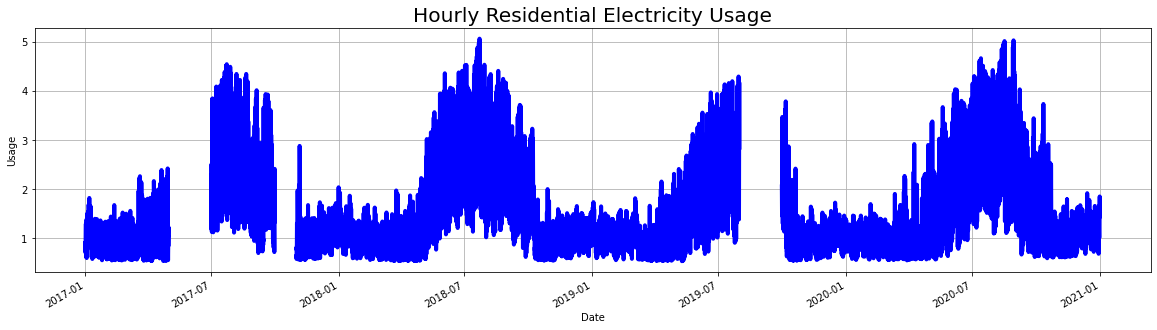

In [34]:
# Plot residential usage against time
plt.subplots(figsize=(20, 5))
plt.style.use('fivethirtyeight')
ax = df_resi_wmrg.value.plot(color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Usage')
ax.set_title('Hourly Residential Electricity Usage')
plt.show()

In [35]:
# Set the dataframe index as 'start_time_local'
df_comm_wmrg = df_comm_wmrg.set_index('start_time_local')

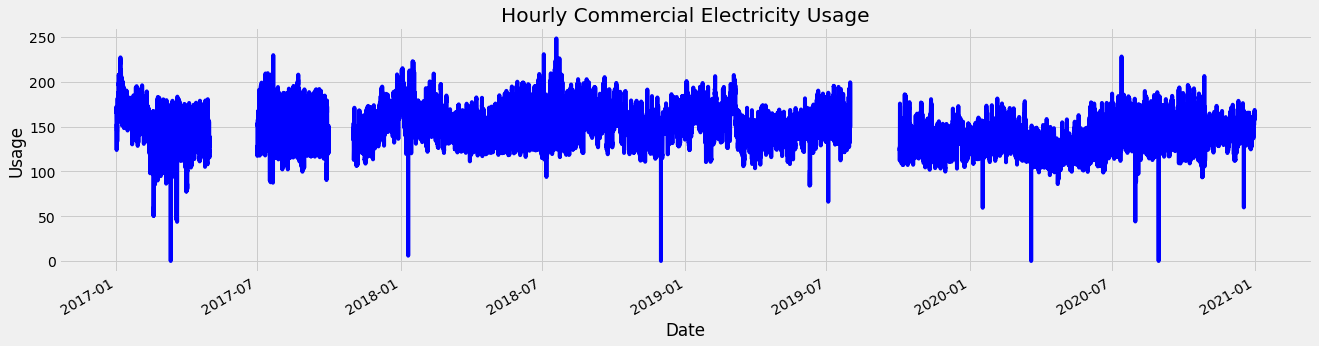

In [36]:
# Plot commercial usage against time
plt.subplots(figsize=(20, 5))
plt.style.use('fivethirtyeight')
ax = df_comm_wmrg.value.plot(color='blue')
ax.set_xlabel('Date')
ax.set_ylabel('Usage')
ax.set_title('Hourly Commercial Electricity Usage')
plt.show()

#####  From the plot of the usage data against time we see that
* Both residential and commercial usage data are missing quite a few values in the year 2017 and 2019.
* <span style="color:blue"> Residential usage shows a seasonal pattern, with relatively large usage in the summer months</span>
* Commercial usage on the other hand, does not have an obvious seasonal pattern. 

##### <span style="color:purple"> Owing to strong seasonality, the missing data in residential usage will be filled using the average usage value for the same hour in the remaining years. This is a reasonable thing to do for businesses as well.</span>

##### Lets identify the missing data ranges

In [37]:
# Total number of missing data points

print("Residential data is missing %s usages" %(len(df_resi_wmrg[df_resi_wmrg.value.isnull()])))
print("Residential data is missing %s usages in 2017" %(len(df_resi_wmrg[df_resi_wmrg.value.isnull()].loc["2017"])))
print("Residential data is missing %s usages in 2019" %(len(df_resi_wmrg[df_resi_wmrg.value.isnull()].loc["2019"])))

print("Commercial data is missing %s usages" %(len(df_comm_wmrg[df_comm_wmrg.value.isnull()])))
print("Commercial data is missing %s usages in 2017" %(len(df_comm_wmrg[df_comm_wmrg.value.isnull()].loc["2017"])))
print("Commercial data is missing %s usages in 2019" %(len(df_comm_wmrg[df_comm_wmrg.value.isnull()].loc["2019"])))

Residential data is missing 3672 usages
Residential data is missing 2208 usages in 2017
Residential data is missing 1464 usages in 2019
Commercial data is missing 3624 usages
Commercial data is missing 2208 usages in 2017
Commercial data is missing 1416 usages in 2019


##### The missing data is coming entirely from 2017 and 2019. Let's further localize missing data in days

In [38]:
print("Residential data is missing %s usages from May01-June30 2017" %(len(df_resi_wmrg[df_resi_wmrg.value.isnull()]\
                                                                         .loc["2017-05-01":"2017-06-30"])))
print("Residential data is missing %s usages from Oct01-Oct31 2017" %(len(df_resi_wmrg[df_resi_wmrg.value.isnull()]\
                                                                        .loc["2017-10-01":"2017-10-31"])))

print("Commercial data is missing %s usages from May01-June30 2017" %(len(df_comm_wmrg[df_comm_wmrg.value.isnull()]\
                                                                         .loc["2017-05-01":"2017-06-30"])))
print("Commercial data is missing %s usages from Oct01-Oct31 2017" %(len(df_comm_wmrg[df_comm_wmrg.value.isnull()]\
                                                                        .loc["2017-10-01":"2017-10-31"])))

Residential data is missing 1464 usages from May01-June30 2017
Residential data is missing 744 usages from Oct01-Oct31 2017
Commercial data is missing 1464 usages from May01-June30 2017
Commercial data is missing 744 usages from Oct01-Oct31 2017


In [39]:
print("Residential data is missing %s usages from Aug01-Sep30 2019" %(len(df_resi_wmrg[df_resi_wmrg.value.isnull()]\
                                                                        .loc["2019-08-01":"2019-09-30"])))

print("Residential data is missing %s usages from Aug01-Sep28 2019" %(len(df_resi_wmrg[df_resi_wmrg.value.isnull()]\
                                                                        .loc["2019-08-01":"2019-09-28"])))

Residential data is missing 1464 usages from Aug01-Sep30 2019
Residential data is missing 1416 usages from Aug01-Sep28 2019


##### We have 3 chunks of missing usage data and we will impute them as follows:
* <span style="color:blue"> May 01 - June 30 2017 data will be imputed using the average usages from years 2018, 2019 and 2020 for the same period.</span>
* <span style="color:blue"> Oct 01 - Oct 31 2017 data will be imputed using the average usages from years 2018, 2019 and 2020 for the same period.</span>
* <span style="color:blue"> Aug 01 - Sep 30/28 2019 data will be imputed using the average usages from years 2017, 2018 and 2020 for the same period.</span>

In [40]:
# Step 0 Create a data frame to hold the imputed values

df_resi_imp = df_resi_wmrg.copy()

# Step1 Imputation of May 01 - June 30 2017

# Let's obtain the indices (representing date and time) of NaN values between May 01 - June 30 2017
idx1_a = df_resi_wmrg[df_resi_wmrg.value.isnull()]["2017-05-01 00:00:00":"2017-06-30 23:00:00"].index

#Correponding entries in 2018 are obtained by advancing the elements in idx1_a by 1 year. Similarly for 2019 and 2020.
idx1_b = idx1_a + pd.DateOffset(years=1)
idx1_c = idx1_a + pd.DateOffset(years=2)
idx1_d = idx1_a + pd.DateOffset(years=3)

In [41]:
# Step2 Imputation of Aug 01 - Aug 31 2019

# Let's obtain the indices (representing date and time) of NaN values between Oct 01 - Oct 31 2017
idx2_a = df_resi_wmrg[df_resi_wmrg.value.isnull()]["2017-10-01 00:00:00":"2017-10-31 23:00:00"].index

#Correponding entries in 2018 are obtained by advancing the elements in idx2_a by 1 year. Similarly for 2019 and 2020.
idx2_b = idx2_a + pd.DateOffset(years=1)
idx2_c = idx2_a + pd.DateOffset(years=2)
idx2_d = idx2_a + pd.DateOffset(years=3)

In [42]:
# Step3 Imputation of Aug1 - Sep 30 2019

# Let's obtain the indices (representing date and time) of NaN values between Aug 01 - Sep 30 2017
idx3_a = df_resi_wmrg[df_resi_wmrg.value.isnull()]["2019-08-01 00:00:00":"2019-09-30 23:00:00"].index

#Correponding entries in 2018 are obtained by subtracting the elements in idx3_a by 1 year. Similarly for 2017 and 2020.
idx3_b = idx3_a + pd.DateOffset(years=-2)
idx3_c = idx3_a + pd.DateOffset(years=-1)
idx3_d = idx3_a + pd.DateOffset(years=1)

In [43]:
# The 3 for loops below are not very efficient and need to be vectorized.

for i in range(len(idx1_a)):
    df_resi_imp.loc[str(idx1_a[i]),'value'] = (df_resi_wmrg.loc[str(idx1_b[i]),'value']\
                                              + df_resi_wmrg.loc[str(idx1_c[i]),'value']\
                                              + df_resi_wmrg.loc[str(idx1_d[i]),'value'])/3.0  

In [44]:
for i in range(len(idx2_a)):
    df_resi_imp.loc[str(idx2_a[i]),'value'] = (df_resi_wmrg.loc[str(idx2_b[i]),'value']\
                                              + df_resi_wmrg.loc[str(idx2_c[i]),'value']\
                                              + df_resi_wmrg.loc[str(idx2_d[i]),'value'])/3.0   

In [45]:
for i in range(len(idx3_a)):
    df_resi_imp.loc[str(idx3_a[i]),'value'] = (df_resi_wmrg.loc[str(idx3_b[i]),'value']\
                                              + df_resi_wmrg.loc[str(idx3_c[i]),'value']\
                                              + df_resi_wmrg.loc[str(idx3_d[i]),'value'])/3.0   

In [46]:
# Ensure NaN values in 'value' are filled in
df_resi_imp["2017-05-01 00:00:00":"2017-06-30 23:00:00"].head()

,uid,proxy_date,value,temperature,dew_point,humidity,heat_index,wind_chill,wind_direction,wind_speed,cloud_cover,wet_bulb_temp,solar_irradiance,precipitation
start_time_local,,,,,,,,,,,,,,
2017-05-01 00:00:00,RESI,2017-05-01,1.058610,55.0,34.0,45.0,55.0,55.0,260.0,10.3,0.0,45.1,0.0,0.0
2017-05-01 01:00:00,RESI,2017-05-01,0.923205,54.0,34.0,47.0,54.0,54.0,290.0,9.2,0.0,44.6,0.0,0.0
2017-05-01 02:00:00,RESI,2017-05-01,0.836558,53.1,34.0,48.0,53.1,53.1,290.0,11.4,0.0,44.1,0.0,0.0
2017-05-01 03:00:00,RESI,2017-05-01,0.781668,52.0,35.1,52.0,52.0,52.0,310.0,10.3,0.0,44.1,0.0,0.0
2017-05-01 04:00:00,RESI,2017-05-01,0.756881,51.1,35.1,54.0,51.1,51.1,300.0,9.2,0.0,43.5,0.0,0.0


In [47]:
# Ensure NaN values in 'value' are filled in
df_resi_imp["2017-10-01 00:00:00":"2017-10-31 23:00:00"].head()

,uid,proxy_date,value,temperature,dew_point,humidity,heat_index,wind_chill,wind_direction,wind_speed,cloud_cover,wet_bulb_temp,solar_irradiance,precipitation
start_time_local,,,,,,,,,,,,,,
2017-10-01 00:00:00,RESI,2017-10-01,1.520750,71.1,52.0,51.0,71.1,71.1,100.0,5.8,75.0,59.4,0.0,0.0
2017-10-01 01:00:00,RESI,2017-10-01,1.350488,69.1,53.1,57.0,69.1,69.1,110.0,5.8,75.0,59.2,0.0,0.0
2017-10-01 02:00:00,RESI,2017-10-01,1.221504,69.1,54.0,59.0,69.1,69.1,100.0,4.7,75.0,59.7,0.0,0.0
2017-10-01 03:00:00,RESI,2017-10-01,1.149910,68.0,55.0,63.0,68.0,68.0,120.0,6.9,75.0,59.9,0.0,0.0
2017-10-01 04:00:00,RESI,2017-10-01,1.106522,68.0,55.0,63.0,68.0,68.0,120.0,5.8,75.0,59.9,0.0,0.0


In [48]:
# Ensure NaN values in 'value' are filled in
df_resi_imp["2019-08-01 00:00:00":"2019-09-30 23:00:00"].head()

,uid,proxy_date,value,temperature,dew_point,humidity,heat_index,wind_chill,wind_direction,wind_speed,cloud_cover,wet_bulb_temp,solar_irradiance,precipitation
start_time_local,,,,,,,,,,,,,,
2019-08-01 00:00:00,RESI,2019-08-01,1.871118,82.0,69.1,64.0,85.3,82.0,160.0,6.9,0.0,72.3,0.0,0.0
2019-08-01 01:00:00,RESI,2019-08-01,1.613659,81.0,69.1,67.0,84.0,81.0,160.0,5.8,0.0,72.3,0.0,0.0
2019-08-01 02:00:00,RESI,2019-08-01,1.431661,81.0,70.0,69.0,84.4,81.0,160.0,5.8,0.0,72.9,0.0,0.0
2019-08-01 03:00:00,RESI,2019-08-01,1.302533,79.0,70.0,73.0,79.0,79.0,160.0,3.4,50.0,72.1,0.0,0.0
2019-08-01 04:00:00,RESI,2019-08-01,1.218426,78.1,70.0,76.0,78.1,78.1,170.0,6.9,50.0,72.1,0.0,0.0


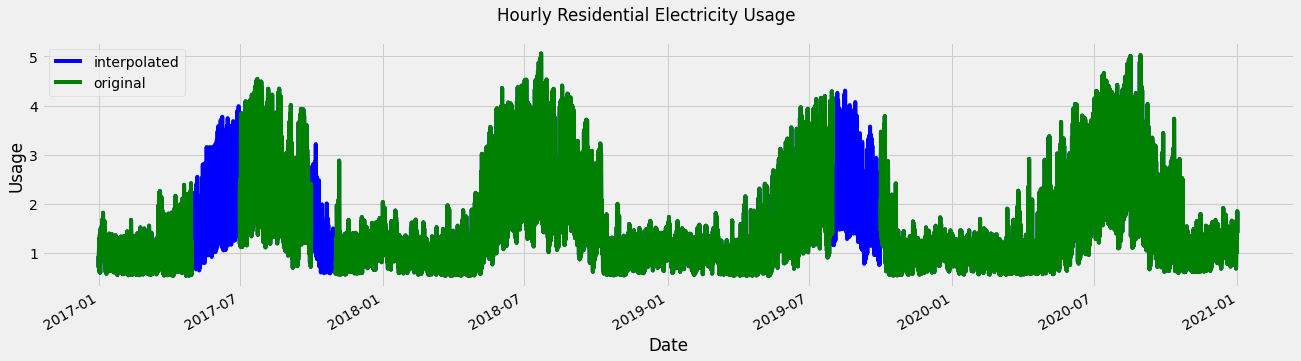

In [49]:
# Plot residential usage of original and imputed data against time
plt.subplots(figsize=(20, 5))
plt.style.use('fivethirtyeight')
df_resi_imp.value.plot(color='blue', label='interpolated')
df_resi_wmrg.value.plot(color='green', label='original')
plt.xlabel('Date')
plt.ylabel('Usage')
plt.suptitle('Hourly Residential Electricity Usage')
plt.legend(loc="upper left")
plt.show()

### Feature Engineering

In [50]:
# Create features that will be useful for modeling
df_resi_imp['value_shf_1'] = df_resi_imp.value.shift()
df_resi_imp['value_shf_4'] = df_resi_imp.value.shift(periods=4)
df_resi_imp['value_shf_8'] = df_resi_imp.value.shift(periods=8)
df_resi_imp['value_shf_12'] = df_resi_imp.value.shift(periods=12)
df_resi_imp['value_shf_24'] = df_resi_imp.value.shift(periods=24)
df_resi_imp['roll_sm_12'] = df_resi_imp.value.rolling(12).aggregate([np.mean])
df_resi_imp['roll_sm_24'] = df_resi_imp.value.rolling(24).aggregate([np.mean])

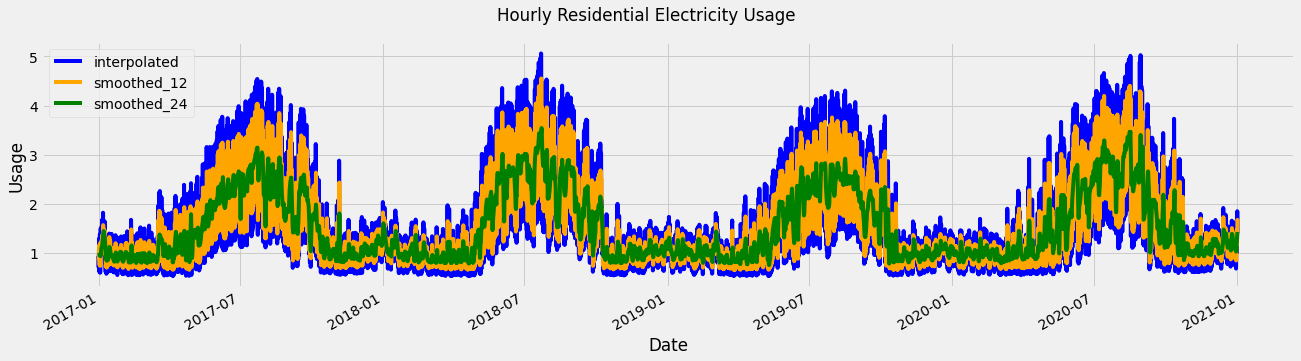

In [51]:
# Plot residential usage of original and imputed data against time
plt.subplots(figsize=(20, 5))
plt.style.use('fivethirtyeight')
df_resi_imp.value.plot(color='blue', label='interpolated')
df_resi_imp.roll_sm_12.plot(color='orange', label='smoothed_12')
df_resi_imp.roll_sm_24.plot(color='green', label='smoothed_24')
plt.xlabel('Date')
plt.ylabel('Usage')
plt.suptitle('Hourly Residential Electricity Usage')
plt.legend(loc="upper left")
plt.show()

In [52]:
X = df_resi_imp.drop(['uid','proxy_date'], axis =1).dropna().copy()
y = X.value
X = X.drop(['value'], axis=1)

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35036 entries, 2017-01-02 00:00:00 to 2020-12-31 23:00:00
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature       35036 non-null  float64
 1   dew_point         35036 non-null  float64
 2   humidity          35036 non-null  float64
 3   heat_index        35036 non-null  float64
 4   wind_chill        35036 non-null  float64
 5   wind_direction    35036 non-null  float64
 6   wind_speed        35036 non-null  float64
 7   cloud_cover       35036 non-null  float64
 8   wet_bulb_temp     35036 non-null  float64
 9   solar_irradiance  35036 non-null  float64
 10  precipitation     35036 non-null  float64
 11  value_shf_1       35036 non-null  float64
 12  value_shf_4       35036 non-null  float64
 13  value_shf_8       35036 non-null  float64
 14  value_shf_12      35036 non-null  float64
 15  value_shf_24      35036 non-null  float64
 16  roll_

In [54]:
#We perform a simple ridge regression

y_pred = Ridge(alpha=1).fit(X,y).predict(X)

In [55]:
print(y_pred)

[0.8243361  0.68882655 0.61742851 ... 1.54429455 1.43659971 1.37673988]


In [56]:
results = y.copy()
results = results.reset_index()
results['pred'] = y_pred
results = results.set_index('start_time_local')
results.head()

,value,pred
start_time_local,,
2017-01-02 00:00:00,0.802141,0.824336
2017-01-02 01:00:00,0.709269,0.688827
2017-01-02 02:00:00,0.651314,0.617429
2017-01-02 03:00:00,0.614704,0.622105
2017-01-02 04:00:00,0.608291,0.630890


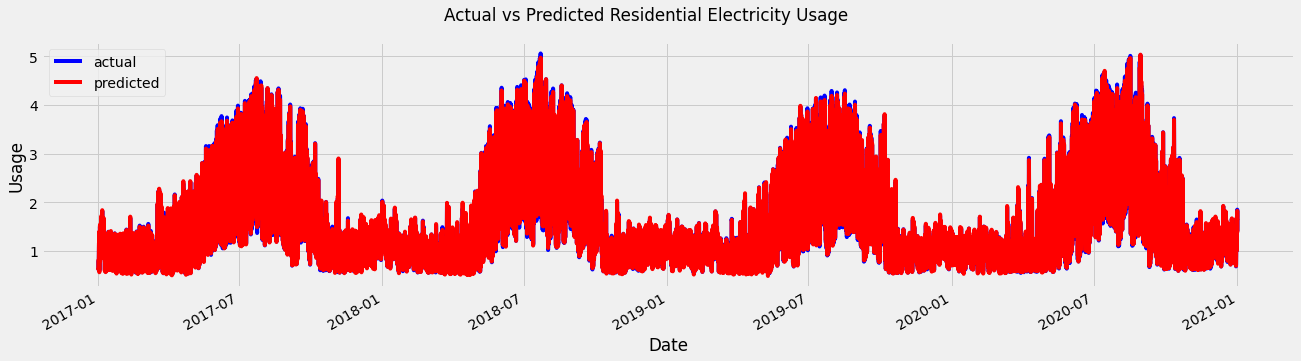

In [57]:
# Plot residential usage of original and imputed data against time
plt.subplots(figsize=(20, 5))
plt.style.use('fivethirtyeight')
results.value.plot(color='blue', label='actual')
results.pred.plot(color='red', label='predicted')
plt.xlabel('Date')
plt.ylabel('Usage')
plt.suptitle('Actual vs Predicted Residential Electricity Usage')
plt.legend(loc="upper left")
plt.show()

In [58]:
mdl1_mape = 100*np.sum(np.abs(y_pred-y))/np.sum(y)
print("Model 1 Mean Absolute Percentage In-sample error is", mdl1_mape)

Model 1 Mean Absolute Percentage In-sample error is 2.8439513496724294


##### <span style="color:purple"> Ran out of time for forecasting the usage.  Since I used the distributed lag model, the method to forecast would be to build up the feature vector  for each sample, forecast that sample and move to the next sample.</span>